# Libraries

In [214]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

# Loading the File

In [180]:
trainingSet = pd.read_csv('./train.csv')
testingSet = pd.read_csv('./test.csv')

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

train.csv shape is  (370703, 24)
test.csv shape is  (92676, 23)

        id                         trans_num  trans_date trans_time  \
0   308467  26ad750c2ff71f32631b58913582d70a  2024-01-10   06:49:39   
1   261578  fea9c1efe3f2b97f27ad0ab5409ec861  2024-01-06   02:37:50   
2      341  2ae350b982be840f3666273e0c2f3a05  2024-01-18   21:40:21   
3  1147639  bbdd8adfc0a34ed0e817f809193c85c0  2024-01-21   16:20:15   
4   314152  fc7756004dc2a9bc450eb894a670b804  2024-01-21   19:36:26   

    unix_time        category     amt            cc_num    first     last  \
0  1704887379        misc_pos  188.38      676355457570   Andrea  Johnson   
1  1704526670     grocery_pos  102.63   377178373574671   Rhonda   Chavez   
2  1705632021   entertainment    1.62  3599292013370451  Stephen     Khan   
3  1705872015  health_fitness    5.64  3594292572430345   Justin   Reilly   
4  1705883786  health_fitness   97.09  4867547663675548    Alice   Duarte   

   ...    zip      lat      long city_pop    

# Adding Features

In [336]:
def add_features_to(df):
    # This is where you can do all your feature extraction
    # Convert text data into numerical values for machine learning models
   label_encoder = LabelEncoder()
   df['category_encoded'] = label_encoder.fit_transform(df['category'])
   df['job_encoded']=label_encoder.fit_transform(df['job'])
   df['merchant_encoded']= label_encoder.fit_transform(df['merchant'])
   df['trans_num_encoded']= label_encoder.fit_transform(df['trans_num'])
   df['gender_encoded']= label_encoder.fit_transform(df['gender'])
   df['state_encoded']=label_encoder.fit_transform(df['state'])
   # Convert `dob` and `trans_date` to datetime
   df['dob'] = pd.to_datetime(df['dob'])
   df['trans_date'] = pd.to_datetime(df['trans_date'])
   # Calculate age
   df['age'] = df['trans_date'].dt.year - df['dob'].dt.year
   return df

# Process the DataFrame
train = add_features_to(trainingSet)
X_submission = add_features_to(testingSet)
# The training set is where the score is not null
X_train =  train[train['is_fraud'].notnull()]

# Sample + Split into Training & Testing Set 

In [338]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['is_fraud']),
    X_train['is_fraud'],
    test_size=1/4.0,
    random_state=0
)

# Features Selection

In [340]:
features = ['amt','category_encoded','unix_time','age','gender_encoded']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [342]:
from sklearn.ensemble import HistGradientBoostingClassifier 
best_hg_model = HistGradientBoostingClassifier(
    max_iter=2000,
    learning_rate=0.05,
    max_leaf_nodes=120,
    min_samples_leaf=40,
    random_state=42
)
# Fitting the model
best_hg_model.fit(X_train_select, Y_train)

# Making predictions
best_hg_preds = best_hg_model.predict(X_test_select)
print("HG Accuracy:",f1_score(Y_test,best_hg_preds))

HG Accuracy: 0.9710626185958254


# Confusion Matrix

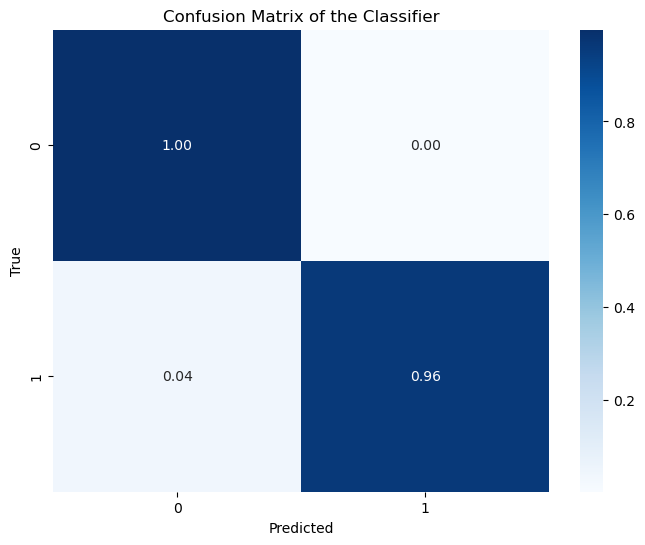

In [300]:
# Confusion Matrix
cm = confusion_matrix(Y_test, best_hg_preds, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2f")
plt.title('Confusion Matrix of the Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Saving The File

In [302]:
# Create the submission file
X_submission['is_fraud'] = best_hg_model.predict(X_submission_select)
submission = X_submission[['id', 'is_fraud']]
print(submission.shape)
submission.to_csv("./submission.csv", index=False)

(92676, 2)
